In [142]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skimage import feature, img_as_ubyte,measure,color,morphology, io, exposure
from skimage.transform import rescale, resize, downscale_local_mean,rotate
from skimage.segmentation import slic, mark_boundaries
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, precision_score, pairwise
from imblearn.over_sampling import RandomOverSampler
import os
import cv2
import math
import joblib

In [143]:
im = plt.imread("example.jpg")
seg = plt.imread("example_segmentation.png")

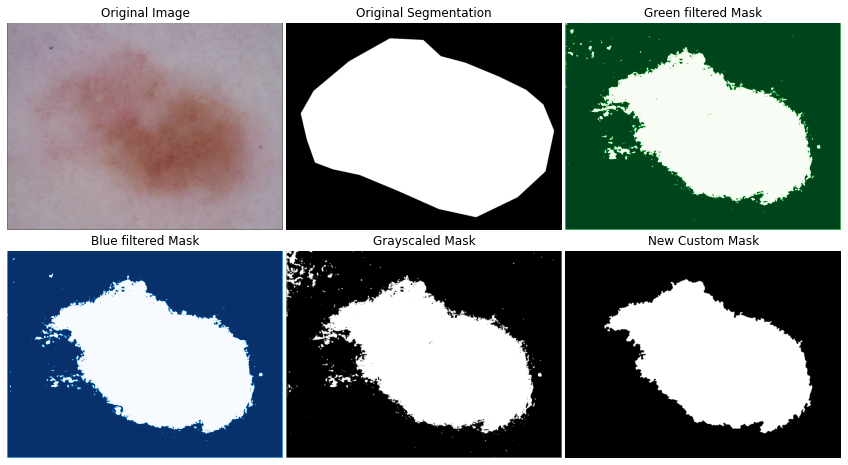

In [144]:
#greyscaling function
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

def create_custom_mask(im,seg):
    #Slightly increase contrast for better color detection 
    im = exposure.rescale_intensity(im) 

    #Keep green values, blue values and greyscale images in an attempt
    #to make red colors as low as possible (since most of the lesions are red)
    #This also removes any colored circles (if present)
    gray_1 = exposure.rescale_intensity(im[:,:,1]) #green only
    gray_2 = exposure.rescale_intensity(im[:,:,2]) #blue only
    gray_3 = exposure.rescale_intensity(rgb2gray(im)) #all greyscaled
    
    imlist = []
    difflist = []
    same_counter = 0
    index = 0
    #For loop that creates a mask at different thresholds of color intensity
    #quant is a quantile threshold based on the color histogram of gray_1, gray_2, and gray_3
     
        
    #first mask with green only
    mymask_1 = gray_1 < np.quantile(gray_1,0.35) 
    #second mask with blue only
    mymask_2 = gray_2 < np.quantile(gray_2,0.35) 
    #third mask with greyscaled image
    mymask_3 = gray_3 < np.quantile(gray_3,0.35)

    #Superpose all masks (including original segment) and keep joint elements
    better_mask = mymask_1.astype('int32')+mymask_2.astype('int32')+mymask_3.astype('int32')
    fixed_mask = better_mask.copy() + seg

    #make mask boolean
    fixed_mask[fixed_mask < 4] = 0
    fixed_mask[fixed_mask == 4] = 1
    fixed_mask = fixed_mask.astype("bool")

    #Morphology transformations to generalize mask
    fixed_mask = morphology.binary_opening(fixed_mask,morphology.disk(2)) #Removes hairs
    fixed_mask = morphology.binary_closing(fixed_mask,morphology.disk(3)) #Closes small disconnected areas
    fixed_mask = morphology.remove_small_holes(fixed_mask,100000) #Fills in holes and gaps in the mask
    fixed_mask = morphology.remove_small_objects(fixed_mask,3000) #Removes small clusters outside the main masked area

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8))
    axes[0,0].imshow(im)
    axes[0,0].set_title("Original Image")
    axes[0,1].imshow(seg,cmap='gray')
    axes[0,1].set_title("Original Segmentation")
    axes[0,2].imshow(mymask_1,cmap="Greens_r")
    axes[0,2].set_title("Green filtered Mask")
    axes[1,0].imshow(mymask_2,cmap="Blues_r")
    axes[1,0].set_title("Blue filtered Mask")
    axes[1,1].imshow(mymask_3,cmap="gray")
    axes[1,1].set_title("Grayscaled Mask")
    axes[1,2].imshow(fixed_mask,cmap="gray")
    axes[1,2].set_title("New Custom Mask")
    
    axes[0,0].axis('off')
    axes[0,1].axis('off')
    axes[0,2].axis('off')
    axes[1,0].axis('off')
    axes[1,1].axis('off')
    axes[1,2].axis('off')
    plt.subplots_adjust(wspace=-0., hspace=0.1)
create_custom_mask(im,seg)

In [2]:
# importing the features normalised and dropping all the non relevant columns to have a clean start
df = pd.read_csv("../data/processed/ISIC_2017_norm_features.csv")
df = df.drop(["seborrheic_keratosis", "Perimeter", "Area", "image_id", "Red", "Green", "Blue"], axis=1)

df.head()
#Note: for sex, 1 is female, 0 is male

,melanoma,Norm_Compactness,Norm_Asymmetry,Norm_Average Color,Norm_Age,Sex
0,0.0,0.434213,0.565848,0.512858,0.647059,1
1,0.0,0.079822,0.714482,0.513188,0.352941,1
2,1.0,0.312995,0.818309,0.657999,0.705882,1
3,0.0,0.346936,0.747794,0.628721,0.352941,0
4,1.0,0.381283,0.671515,0.458960,0.941176,0


In [3]:
#copying the dataframe. it should be with .copy() but it works like this too
df2 = df.copy().dropna()


# Some noisy features
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
# this is not something that makes sense to me. we add the noise to then ignore it in the next cell
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color","Norm_Age","Sex"]], noise))
y = df2['melanoma'].astype("int32")


In [4]:
##Training KNN with 3 features
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color","Norm_Age","Sex"]], noise))
y = df2['melanoma'].astype("int32")
# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y,random_state = 621)

# the development data is split into training and validation.
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev,random_state = 621)


#OverSampling to compensate for imbalanced dataset
oversample = RandomOverSampler(sampling_strategy = 0.6,random_state = 621)
X_over, y_over = oversample.fit_resample(X_train,y_train)

roc_test_dict = {}
X_over = X_over[:,0:3] # Take only wanted features
X_val = X_val[:, 0:3] # Take only wanted features
X_test = X_test[:,0:3]
neigh = int(math.sqrt(len(X_over)))
neigh

for i in range(1, neigh*4):
    #train the model with different values of the neighbors
    knn1 = KNeighborsClassifier(n_neighbors=i) 
    knn1trained = knn1.fit(X_over, y_over)

    #Select the same features as before
    y_val_knn1 = knn1trained.predict_proba(X_val)
    y_test_knn1 = knn1trained.predict_proba(X_test)


    #adding the roc_score value to the dictionary to assess which is the best
    # can be calculated with another calculation, but it would be time consuming to do both to show they are identical
    fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:,1])
    roc_val = auc(fpr,tpr)
    fpr, tpr, threshold = roc_curve(y_test, y_test_knn1[:,1])
    roc_test = auc(fpr,tpr)
    roc_test_dict[i] = np.mean([roc_val,roc_test])


# getting all the values with the highest roc score
knn_final_3 = KNeighborsClassifier(n_neighbors=max(roc_test_dict, key=roc_test_dict.get)) 
knn_final_3 = knn_final_3.fit(X_over, y_over)
fpr, tpr, threshold = roc_curve(y_test, knn_final_3.predict_proba(X_test)[:,1])
print(auc(fpr,tpr))

0.7019409826672397


In [5]:
##Training KNN with 5 features
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color","Norm_Age","Sex"]], noise))
y = df2['melanoma'].astype("int32")
# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y,random_state = 621)

# the development data is split into training and validation.
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev,random_state = 621)


#OverSampling to compensate for imbalanced dataset
oversample = RandomOverSampler(sampling_strategy = 0.6,random_state = 621)
X_over, y_over = oversample.fit_resample(X_train,y_train)

roc_test_dict = {}
X_over = X_over[:,0:5] # Take only wanted features
X_val = X_val[:, 0:5] # Take only wanted features
X_test = X_test[:,0:5]
neigh = int(math.sqrt(len(X_over)))
neigh

for i in range(1, neigh*4):
    #train the model with different values of the neighbors
    knn1 = KNeighborsClassifier(n_neighbors=i) 
    knn1trained = knn1.fit(X_over, y_over)

    #Select the same features as before
    y_val_knn1 = knn1trained.predict_proba(X_val)
    y_test_knn1 = knn1trained.predict_proba(X_test)


    #adding the roc_score value to the dictionary to assess which is the best
    # can be calculated with another calculation, but it would be time consuming to do both to show they are identical
    fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:,1])
    roc_val = auc(fpr,tpr)
    fpr, tpr, threshold = roc_curve(y_test, y_test_knn1[:,1])
    roc_test = auc(fpr,tpr)
    roc_test_dict[i] = np.mean([roc_val,roc_test])


# getting all the values with the highest roc score
knn_final_5 = KNeighborsClassifier(n_neighbors=max(roc_test_dict, key=roc_test_dict.get)) 
knn_final_5 = knn_final_5.fit(X_over, y_over)
fpr, tpr, threshold = roc_curve(y_test, knn_final_5.predict_proba(X_test)[:,1])
print(auc(fpr,tpr))

0.7535632430883827


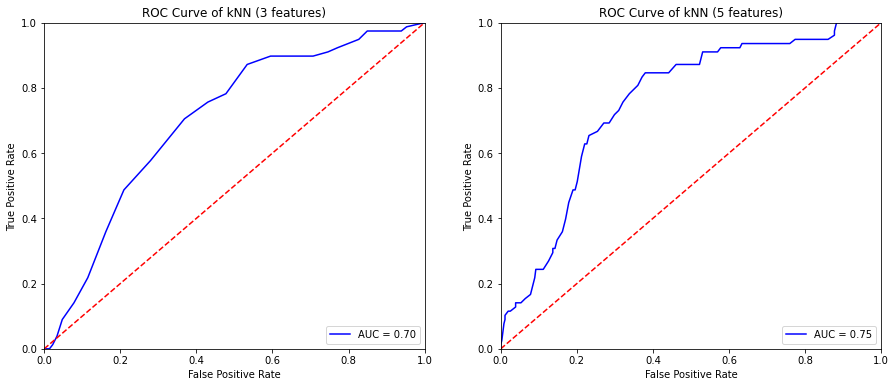

In [8]:
"""Print the graphs"""
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color","Norm_Age","Sex"]], noise))
y = df2['melanoma'].astype("int32")
# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y,random_state = 621)

# the development data is split into training and validation.
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev,random_state = 621)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
fpr, tpr, threshold = roc_curve(y_test, knn_final_3.predict_proba(X_test[:,0:3])[:, 1])
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].legend(loc = 'lower right')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('True Positive Rate')
axes[0].set_xlabel('False Positive Rate')
axes[0].set_title('ROC Curve of kNN (3 features)')


fpr, tpr, threshold = roc_curve(y_test, knn_final_5.predict_proba(X_test[:,0:5])[:, 1])
axes[1].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc(fpr, tpr))
axes[1].plot([0, 1], [0, 1],'r--')
axes[1].legend(loc = 'lower right')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('True Positive Rate')
axes[1].set_xlabel('False Positive Rate')
axes[1].set_title('ROC Curve of kNN (5 features)');